# Purpose: Experimentation with using 2D correlation to match detections of streaks. This work is still currently in progress.

In [1]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import urllib
from tqdm.notebook import tqdm
import os
import astropy.wcs as wcs
from astropy.io import fits
import sep
from collections import defaultdict
import subprocess
import tables
# %matplotlib notebook

In [2]:
%matplotlib agg

Using matplotlib backend: agg


In [2]:
fileh = tables.open_file('/mnt/etdisk9/ztf_neos/real_streaks/realstreaks_new.h5', mode='r')
train_images = fileh.root.data
train_labels = np.ones(len(train_images))

In [3]:
with open("/home/fwang/Pipeline/filteredrealstreaksmetadata.pkl", "rb") as f:
    streak_metadata = pkl.load(f)

In [4]:
name2indexes = defaultdict(list)
for i, meta in enumerate(streak_metadata):
    name2indexes[meta[1]["name"] + " " + meta[1]["obsdate"].split()[0]].append(i)

In [5]:
name2indexes

defaultdict(list,
            {'2018 PD20 2018-08-11': [0],
             '2019 AE9 2019-01-12': [1],
             '2018 WE1 2018-11-25': [2],
             '2018 NX 2018-07-09': [3],
             '2018 VO5 2018-11-06': [4],
             '2018 VO5 2018-11-07': [5],
             '2019 AW2 2018-12-29': [6],
             '2018 WH 2018-11-16': [7],
             '2018 VJ10 2018-11-15': [8, 9, 10],
             '2010 WC9 2018-05-14': [11],
             '2019 HE 2019-04-21': [12],
             '2018 RC 2018-09-06': [13, 14],
             '2018 RC 2018-09-08': [15],
             '2019 FA 2019-03-16': [16],
             '2018 GY3 2018-04-11': [17, 18, 19],
             '2018 LV3 2018-06-14': [20, 21],
             '2019 EN2 2019-03-14': [22],
             '2018 HW1 2018-04-21': [23],
             '2018 VX1 2018-11-09': [24, 25, 26],
             '2018 VX1 2018-11-11': [27],
             '2018 GN 2018-04-09': [28, 29, 30, 31, 32],
             '2018 NH 2018-07-03': [33, 34],
             '2018 VG 

(array([216., 156.,  26.,  19.,  11.,   9.,   7.,   7.,   0.,   1.,   1.,
          0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 <a list of 19 Patch objects>)

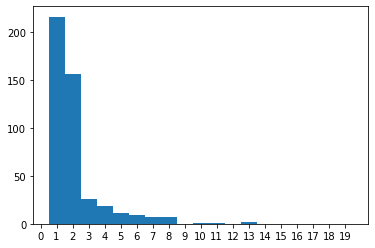

In [6]:
plt.xticks(np.arange(0, 20, 1))
plt.hist([len(l) for l in name2indexes.values()], bins=np.arange(0.5, 20, 1))

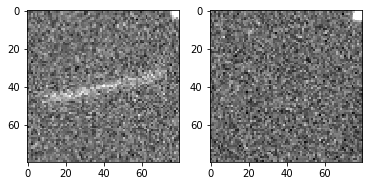

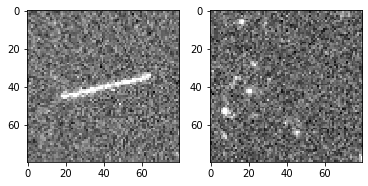

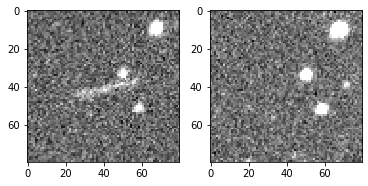

In [213]:
name = "2018 VJ10 2018-11-15"
for i in name2indexes[name]:
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(train_images[i][..., 0], cmap="gray")
    ax[1].imshow(train_images[i][..., 1], cmap="gray")

In [8]:
streak_metadata

[['ztf_20180811311319_000543_zg_c04_o_q4_sciimg.fits',
  {'ra_obj': '310.070995',
   'dec_obj': '8.688498',
   'sun_dist': '1.0176',
   'geo_dist': '0.0045',
   'dist_ctr': '0.4740',
   'phase': '26.1428',
   'vmag': '17.18',
   'match': '1',
   'ra': '310.49350894999998',
   'dec': '8.4646315300000001',
   'filefracday': '20180811311319',
   'field': '543',
   'ccdid': '4',
   'qid': '4',
   'rcid': '15',
   'fid': '1',
   'filtercode': 'zg',
   'pid': '587311351515',
   'nid': '587',
   'expid': '58731135',
   'itid': '1',
   'imgtypecode': 'o',
   'obsdate': '2018-08-11 07:28:21.925',
   'obsjd': '2458341.8113541999',
   'ra1': '310.9277482',
   'dec1': '8.9004306900000003',
   'ra2': '310.05337950000001',
   'dec2': '8.8945687400000004',
   'ra3': '310.06020591999999',
   'dec3': '8.0283519699999992',
   'ra4': '310.93232171',
   'dec4': '8.0343211599999993',
   'ast_loc': [(310.07044, 8.68849), (310.06811, 8.68788)],
   'length_arcseconds': 8.670695473937098,
   'name': '2018 PD20

In [9]:
def sci_file_to_diff_dir(scifile):
    return "/mnt/etdisk9/ztf_neos/ztf_visible/difference/" + scifile[:-len("sciimg.fits")] + "scimrefdiffimg.fits"


def download(link, directory):
    if not os.path.isfile(directory):
        try:
            urllib.request.urlretrieve(link, directory)
        except Exception as e:
            print(e)
            print(link, directory)
        
def download_diff(directory):
    name = directory.split("/")[-1]
    vals = name.split("_")
    link = "https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/" + vals[1][:4] + "/" + vals[1][4:8] + "/" + vals[1][8:] + "/" + name + ".fz"
    download(link, directory + ".fz")
    subprocess.run(["funpack", directory + ".fz"])
    
    
size = 80
def getCrop(img_file, ast_loc, clip=True):
    
    img = fits.getdata(img_file)
    
    bkg = sep.Background(img.astype(np.float32))
    img = (img - bkg.back())/bkg.rms()
    if clip:
        img = np.clip(img, -5, 5)
    
    wcs_img = wcs.WCS(img_file)
    (x1, y1), (x2, y2) = wcs_img.all_world2pix(ast_loc, 0, ra_dec_order=True)
    midx = int((x1 + x2) // 2)
    midy = int((y1 + y2) // 2)
    
    crop = img[midy - size//2:midy + size//2, midx - size//2:midx + size//2]
    
    return crop, [(x1, y1), (x2, y2)]

In [28]:
download_diff(sci_file_to_diff_dir("ztf_20180811311319_000543_zg_c04_o_q4_sciimg.fits"))

Already Done: https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2018/0811/311319/ztf_20180811311319_000543_zg_c04_o_q4_scimrefdiffimg.fits.fz /mnt/etdisk9/ztf_neos/ztf_visible/difference/ztf_20180811311319_000543_zg_c04_o_q4_scimrefdiffimg.fits.fz


In [32]:
crop, pixs = getCrop(sci_file_to_diff_dir("ztf_20180811311319_000543_zg_c04_o_q4_sciimg.fits"), [(310.07044, 8.68849), (310.06811, 8.68788)])

In [40]:
plt.imshow(crop, cmap="gray")

In [17]:
crops = defaultdict(list)

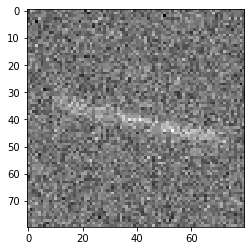

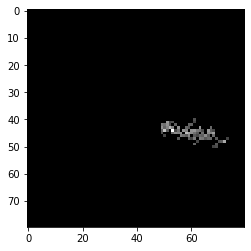

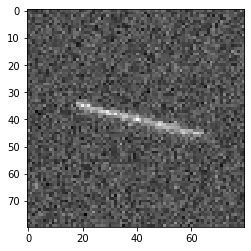

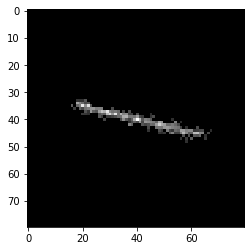

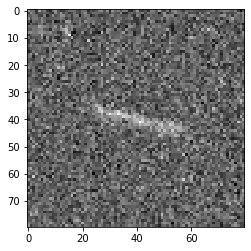

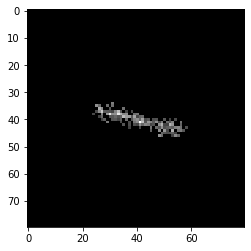

In [214]:
name = "2018 VJ10 2018-11-15"
crops[name].clear()
for i in tqdm(name2indexes[name]):
    diff_dir = sci_file_to_diff_dir(streak_metadata[i][0])
    download_diff(diff_dir)
    try:
        crop, pixs = getCrop(diff_dir, streak_metadata[i][1]["ast_loc"], clip=False)
    except Exception as e:
        print(e)
        continue
    if crop.size != size * size:
        continue
    crops[name].append(crop)
    plt.figure()
    plt.imshow(crop, cmap="gray")
    plt.figure()
    plt.imshow(crop_streak(crop), cmap="gray")

In [215]:
%%time
signal.convolve2d(mask1.astype(int), mask2.astype(int), mode="same") / max(np.sum(mask1), np.sum(mask2))

CPU times: user 68.7 ms, sys: 0 ns, total: 68.7 ms
Wall time: 68.1 ms


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

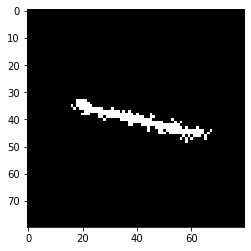

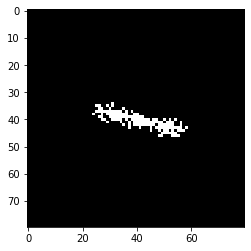

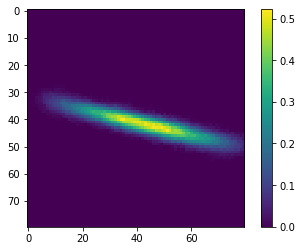

In [218]:
mask1 = crop_streak(list(crops.values())[4][1], True)
mask2 = crop_streak(list(crops.values())[4][2], True)
plt.imshow(mask1, cmap="gray")
plt.figure()
plt.imshow(mask2, cmap="gray")
plt.figure()
plt.imshow(signal.convolve2d(mask1.astype(int), mask2.astype(int), mode="same") / max(np.sum(mask1), np.sum(mask2)))
plt.colorbar()

In [178]:
def get_moment_custom(img):
    crop = crop_streak(img)
    bkg = sep.Background(img.astype(np.float32))
    crop -= bkg.back()
    crop /= bkg.rms() * 5
    crop = np.clip(crop, -1, 1)
    print(np.average(np.sum(crop, axis=0) * np.arange(size)))
    print(np.average(np.sum(crop, axis=1) * np.arange(size)))
get_moment_custom(crop_images[0])
get_moment_custom(crop_images[1])

44.810099934227765
38.3964461427182
86.35795401893556
86.1290039281128


In [169]:
crop_images = crops["2018 LB 2018-06-01"]
moments = [getMoments(crop_image, order=1) for crop_image in crop_images]

In [168]:
getMoments(crop_images[0], order=1)

array([[ 6.74204318e+02, -3.19131231e-12],
       [ 2.91322522e-13, -5.31454426e+04]])

In [170]:
for i in range(len(moments)):
    for j in range(i + 1, len(moments)):
        print(i, j, np.linalg.norm(moments[i] - moments[j]))

0 1 16891.676039063066
0 2 24624.148342144683
0 3 53127.087844150985
1 2 41515.7772710321
1 3 70018.72709333198
2 3 28502.94982234165


In [12]:
import scipy.signal as signal

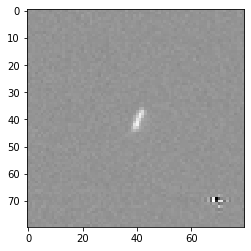

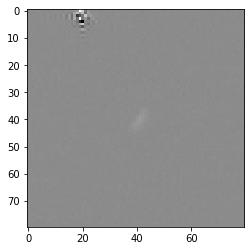

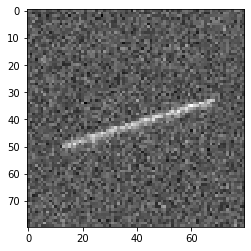

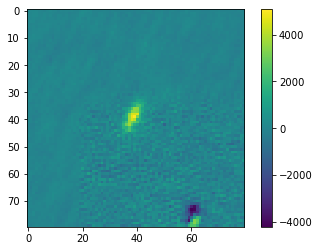

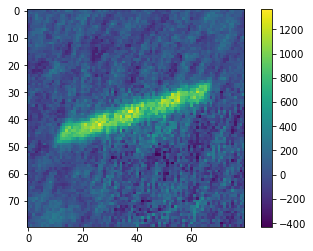

In [21]:
c1 = crops["2018 GU1 2018-04-10"][0]
c2 = crops["2018 GU1 2018-04-10"][6]
c3 = crops["2018 LB 2018-06-01"][0]
plt.imshow(c1, cmap="gray")
plt.figure()
plt.imshow(c2, cmap="gray")
plt.figure()
plt.imshow(c3, cmap="gray")
plt.figure()
plt.imshow(signal.correlate2d(c1, c2, mode="same"))
plt.colorbar()
plt.figure()
plt.imshow(signal.correlate2d(c1, c3, mode="same"))
plt.colorbar()

In [73]:
import numba
# @numba.jit(nopython=True, parallel=True)
# def extract_crop(bool_mask):
from skimage.segmentation import flood_fill
from skimage.measure import moments_central,moments_normalized,moments, label

In [179]:
def crop_streak(crop, ret_mask=False):
    crop = np.copy(crop)
    bkg = sep.Background(crop)
    mask = np.array(crop > bkg.back() + bkg.rms() * 1.3, dtype=np.uint8)
    mask = best_object(label(mask, connectivity=2), 15)
    if ret_mask:
        return mask
    crop[~mask] = 0
    return crop

In [67]:
moments_central(crop_streak(c2))

array([[ 3.49003322e+02,  1.60120886e-13,  9.81864508e+02,
        -1.21458002e+02],
       [ 8.96172025e-13, -6.72936861e+02,  3.18036592e+02,
        -4.22789594e+03],
       [ 1.67785167e+03,  6.72714968e+01,  5.62021837e+03,
        -2.58671237e+03],
       [ 2.77306815e+02, -6.62464370e+03,  2.98373074e+03,
        -4.00600292e+04]])

In [162]:
def getMoments(image, order=3):
    moments = (moments_central(crop_streak(image), order=order))#, order=order)
    moments[~np.isfinite(moments)] = 0
    return moments

In [148]:
print(getMoments(c1))
print(getMoments(c2))
print(getMoments(c3))
print(np.linalg.norm(getMoments(c1) - getMoments(c2)))
print(np.linalg.norm(getMoments(c1) - getMoments(c3)))
print(np.linalg.norm(getMoments(c2) - getMoments(c3)))
# print(moments_central(crop_streak(c2)))
# print(moments_central(crop_streak(c1)))
# print(moments_central(crop_streak(c3)))

[[ 0.00000000e+00  0.00000000e+00  4.92073876e-03  1.42004239e-04]
 [ 0.00000000e+00 -3.68486236e-03  1.96111833e-04 -3.56560480e-05]
 [ 1.10790961e-02 -1.25447335e-04  7.49484609e-05 -3.43511400e-06]
 [ 2.62726810e-04 -9.88482087e-05  7.84028956e-06 -1.41389041e-06]]
[[ 0.00000000e+00  0.00000000e+00  8.06106532e-03 -5.33767627e-05]
 [ 0.00000000e+00 -5.52478264e-03  1.39766532e-04 -9.94570578e-05]
 [ 1.37750900e-02  2.95635912e-05  1.32210062e-04 -3.25720189e-06]
 [ 1.21867146e-04 -1.55838171e-04  3.75712952e-06 -2.70018188e-06]]
[[ 0.00000000e+00  0.00000000e+00  3.75554512e-01 -6.04322462e-03]
 [ 0.00000000e+00 -1.16918428e-01  1.39863351e-03 -7.92409309e-02]
 [ 3.85644500e-02 -4.21399633e-04  2.50120202e-02 -5.02337341e-04]
 [ 2.44485522e-04 -8.12550633e-03  1.26675471e-04 -6.52763734e-03]]
0.004539953136211877
0.39747840826452396
0.3938285209521553


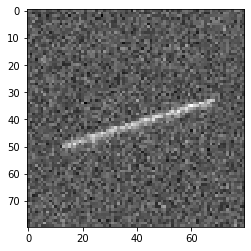

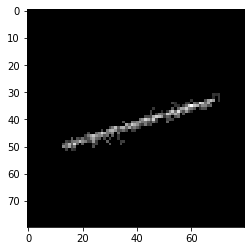

In [120]:
crop = np.copy(c3)
plt.imshow(crop, cmap="gray")
bkg = sep.Background(crop)
plt.figure()
plt.imshow(crop_streak(crop), cmap="gray")
# mask = np.array(crop > bkg.back() + bkg.rms() * 1.3, dtype=np.uint8)
# mask = best_object(label(mask, connectivity=2), 15)
# flood_fill(mask, (size // 2, size//2), 2, inplace=True)
# plt.imshow(mask)
# plt.figure()
# crop[mask!=2] = 0
# plt.imshow(crop, cmap="gray")
# plt.imshow(label(mask, connectivity=2))
# print(best_object(label(mask, connectivity=2), 15))
# print(moments_central(crop))

In [108]:
@numba.jit(nopython=True, parallel=True)
def best_object(labels, area_thresh):
    bounds = np.zeros((np.max(labels), 4), dtype=np.uintc)
    bounds[:, 0] = 9999999
    bounds[:, 2] = 9999999
    
    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            label = labels[i, j] - 1
            if label == -1:
                continue
            bounds[label][0] = min(i, bounds[label][0])
            bounds[label][1] = max(i + 1, bounds[label][1])
            bounds[label][2] = min(j, bounds[label][2])
            bounds[label][3] = max(j + 1, bounds[label][3])
            
#     best_slice = None
    best_binary_img = np.zeros(labels.shape, dtype=np.bool_)
    
    min_area = area_thresh
    
    for i in range(len(bounds)):
        bound = bounds[i]
        if bound[0] == 9999999:
            continue
        y = bound[1] - bound[0]
        x = bound[3] - bound[2]
        
        if y * x < min_area:
            continue
            
        binary_img = labels == (i + 1)
        area = np.sum(binary_img)

        if area > min_area:
#             best_slice = bound
            best_binary_img = binary_img
            min_area = area
    return best_binary_img